# Unit 5 - Financial Planning

In [32]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import json
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [33]:
# Load .env enviroment variables
load_dotenv("APIKey.env")

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [34]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [35]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [36]:
# Fetch current BTC price
btc_fetch = requests.get(btc_url).json()
btc_price = btc_fetch["data"]["1"]["quotes"]["USD"]["price"]

# Fetch current ETH price
eth_fetch = requests.get(eth_url).json()
eth_price = eth_fetch ["data"]["1027"]["quotes"]["USD"]["price"]

# Compute current value of my crpto
my_btc_value = my_btc * btc_price
my_eth_value = my_eth * eth_price

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $74373.60
The current value of your 5.3 ETH is $23016.15


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [37]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [38]:
# Set Alpaca API key and secret
ALPACA_API_KEY = os.getenv("ALPACA_API_KEY")
ALPACA_SECRET_KEY = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
alpaca = tradeapi.REST(
    ALPACA_API_KEY,
    ALPACA_SECRET_KEY,
    api_version = "v2")

In [39]:
# Format current date as ISO format
today = pd.Timestamp("2021-10-30", tz="America/New_York").isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# Get current closing prices for SPY and AGG
# (use a limit=1000 parameter to call the most recent 1000 days of data)
df_portfolio = alpaca.get_barset(tickers, timeframe, end=today, limit=1000).df.sort_index(ascending=False)

# Preview DataFrame
df_portfolio.head()

AGG                                       \
                             open     high      low   close     volume   
time                                                                     
2021-10-29 00:00:00-04:00  114.35  114.780  114.350  114.62  7051614.0   
2021-10-28 00:00:00-04:00  114.71  114.825  114.570  114.65  4971007.0   
2021-10-27 00:00:00-04:00  114.66  114.915  114.425  114.77  6817074.0   
2021-10-26 00:00:00-04:00  114.25  114.380  114.110  114.37  5284755.0   
2021-10-25 00:00:00-04:00  114.06  114.270  114.060  114.17  7088133.0   

                              SPY                                      
                             open    high     low   close      volume  
time                                                                   
2021-10-29 00:00:00-04:00  455.87  459.56  455.56  459.22  58813207.0  
2021-10-28 00:00:00-04:00  455.46  458.40  455.45  458.27  43081788.0  
2021-10-27 00:00:00-04:00  456.45  457.16  453.86  453.92  48219255.0  
2021-10-26 00:00:00-04:00  457.20  458.49  455.56  455.97  49865704.0  
2021-10-25 00:00:00-04:00  454.28  455.90  452.39  455.48  37918548.0

In [40]:
# Pick AGG and SPY close prices
agg_close_price = df_portfolio["AGG"]["close"][0]
spy_close_price = df_portfolio["SPY"]["close"][0]
agg_close_price

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $114.62
Current SPY closing price: $459.22


In [41]:
# Compute the current value of shares
my_agg_value = my_agg * agg_close_price
my_spy_value = my_spy * spy_close_price
# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $22961.00
The current value of your 200 AGG shares is $22924.00


### Savings Health Analysis

In [42]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
crypto_holdings = my_btc_value + my_eth_value
share_holdings = my_agg_value + my_spy_value
# Create savings DataFrame
savings = [crypto_holdings, share_holdings]
df_savings = pd.DataFrame(savings, index=["Crypto", "Shares"], columns=["amount"])
# Display savings DataFrame
display(df_savings)

amount
Crypto  97389.751
Shares  45885.000

array([<AxesSubplot:ylabel='amount'>], dtype=object)

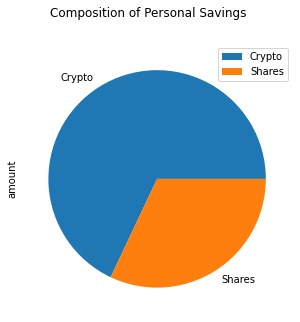

In [43]:
# Plot savings pie chart
df_savings.plot.pie(subplots=True,figsize=(10,5), title="Composition of Personal Savings")

In [44]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = df_savings.sum().item()

# Validate saving health
if total_savings > emergency_fund:
    print("Congratulations on having more than 3x your monthly income in your emergency fund.")
elif total_savings == emergency_fund:
    print("Congratulations on reaching your goal of 3x your monthly income in your emergency fund.")
else:
    print(f'You are ${emergency_fund - total_savings} away from reaching your goal of 3x your monthly income in your emergency fund.')

Congratulations on having more than 3x your monthly income in your emergency fund.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [45]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2016-05-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-05-01', tz='America/New_York').isoformat()

In [46]:
# Get 5 years' worth of historical data for SPY and AGG
# (use a limit=1000 parameter to call the most recent 1000 days of data)
df_stock_data = alpaca.get_barset(
    tickers,
    timeframe,
    start = start_date,
    end = end_date
).df 

# Display sample data
df_stock_data.head()

AGG                                       \
                             open      high       low   close   volume   
time                                                                     
2020-12-07 00:00:00-05:00  117.76  117.8262  117.6900  117.75  4689469   
2020-12-08 00:00:00-05:00  117.88  117.9597  117.7500  117.77  3587353   
2020-12-09 00:00:00-05:00  117.73  117.7800  117.5172  117.62  4720359   
2020-12-10 00:00:00-05:00  117.74  117.9300  117.6900  117.88  4694024   
2020-12-11 00:00:00-05:00  118.01  118.0900  117.9500  118.03  5537449   

                              SPY                                        
                             open      high     low     close    volume  
time                                                                     
2020-12-07 00:00:00-05:00  369.02  369.6200  367.72  369.1200  40456544  
2020-12-08 00:00:00-05:00  367.72  370.7800  367.67  370.1599  32702217  
2020-12-09 00:00:00-05:00  370.88  371.0500  365.95  366.8900  60700254  
2020-12-10 00:00:00-05:00  365.37  367.8600  364.43  366.7200  47851654  
2020-12-11 00:00:00-05:00  364.90  366.7402  363.26  366.2800  47917103

In [47]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_30yr = MCSimulation(
    portfolio_data=df_stock_data,
    weights=[.40, .60],
    num_simulation=500,
    num_trading_days=252*30
)

In [48]:
# Printing the simulation input data
MC_30yr.portfolio_data.head()

AGG                                       \
                             open      high       low   close   volume   
time                                                                     
2020-12-07 00:00:00-05:00  117.76  117.8262  117.6900  117.75  4689469   
2020-12-08 00:00:00-05:00  117.88  117.9597  117.7500  117.77  3587353   
2020-12-09 00:00:00-05:00  117.73  117.7800  117.5172  117.62  4720359   
2020-12-10 00:00:00-05:00  117.74  117.9300  117.6900  117.88  4694024   
2020-12-11 00:00:00-05:00  118.01  118.0900  117.9500  118.03  5537449   

                                           SPY                              \
                          daily_return    open      high     low     close   
time                                                                         
2020-12-07 00:00:00-05:00          NaN  369.02  369.6200  367.72  369.1200   
2020-12-08 00:00:00-05:00     0.000170  367.72  370.7800  367.67  370.1599   
2020-12-09 00:00:00-05:00    -0.001274  370.88  371.0500  365.95  366.8900   
2020-12-10 00:00:00-05:00     0.002211  365.37  367.8600  364.43  366.7200   
2020-12-11 00:00:00-05:00     0.001272  364.90  366.7402  363.26  366.2800   

                                                  
                             volume daily_return  
time                                              
2020-12-07 00:00:00-05:00  40456544          NaN  
2020-12-08 00:00:00-05:00  32702217     0.002817  
2020-12-09 00:00:00-05:00  60700254    -0.008834  
2020-12-10 00:00:00-05:00  47851654    -0.000463  
2020-12-11 00:00:00-05:00  47917103    -0.001200

In [49]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_30yr.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0          1           2          3           4          5    \
0      1.000000   1.000000    1.000000   1.000000    1.000000   1.000000   
1      1.002649   1.009330    1.013058   0.996282    1.003814   1.007955   
2      1.009197   1.003375    1.012022   0.989465    1.005723   1.003959   
3      1.014249   1.006244    1.021214   0.983834    1.010483   1.006137   
4      1.013910   1.010919    1.023973   0.985544    1.011789   1.008263   
...         ...        ...         ...        ...         ...        ...   
7556  59.874235  89.455955  117.116231  69.557684  103.169160  88.339307   
7557  60.834503  89.993261  117.058077  69.048363  103.779336  88.583376   
7558  61.436679  89.349012  117.174601  69.250716  103.974339  88.968134   
7559  61.975983  89.584399  117.515626  69.101049  103.978202  88.325069   
7560  62.076291  89.746423  117.484275  69.445327  104.164257  87.773357   

            6           7          8           9    ...        490  \
0      1.000000    1.000000   1.000000    1.000000  ...   1.000000   
1      0.992732    1.008806   0.998392    0.993520  ...   0.999025   
2      0.988808    1.002299   1.004106    0.997683  ...   1.009158   
3      0.989762    1.005025   1.012455    0.996321  ...   1.010005   
4      0.994792    1.009274   1.012092    1.002449  ...   1.001380   
...         ...         ...        ...         ...  ...        ...   
7556  55.248540  122.272459  47.847731  241.192279  ...  65.057200   
7557  54.958441  123.388420  47.915023  239.998144  ...  65.185458   
7558  55.266068  123.826961  47.730529  239.898281  ...  65.722481   
7559  54.865669  123.203317  47.245215  239.855463  ...  66.525260   
7560  55.080605  123.814691  47.132902  242.265909  ...  67.139680   

             491         492        493        494         495        496  \
0       1.000000    1.000000   1.000000   1.000000    1.000000   1.000000   
1       1.003906    1.002500   1.006133   0.996538    1.003068   1.004163   
2       0.997852    1.005182   1.004363   0.991771    1.006887   0.998338   
3       1.002555    1.003955   0.997800   0.999495    1.002141   1.000436   
4       1.009278    1.016142   1.001564   0.997462    0.996878   0.997057   
...          ...         ...        ...        ...         ...        ...   
7556  174.703337  244.673341  93.121332  84.172951  136.191205  74.012957   
7557  175.420298  246.156068  92.967286  84.191031  136.835157  74.399888   
7558  175.551177  246.306199  92.693568  84.428103  138.804921  74.885049   
7559  176.716796  245.270910  92.793306  84.709540  138.239793  75.361149   
7560  177.878209  244.359486  92.985012  84.314832  137.919005  75.441838   

             497        498         499  
0       1.000000   1.000000    1.000000  
1       0.994342   0.997447    0.998931  
2       0.991338   0.991115    0.995068  
3       0.995381   0.994470    0.988499  
4       0.997558   0.996773    0.993399  
...          ...        ...         ...  
7556  168.801451  53.753840  144.419686  
7557  168.863488  53.720177  143.796315  
7558  168.670000  53.923618  143.794001  
7559  168.138924  53.490503  142.639338  
7560  167.443424  53.318204  143.618127  

[7561 rows x 500 columns]

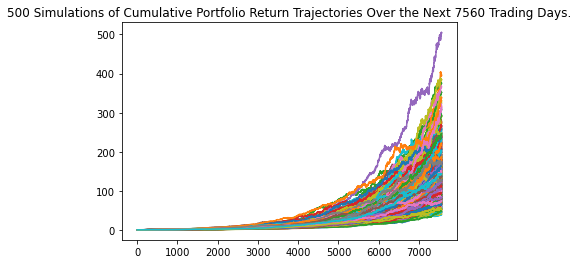

In [51]:
# Plot simulation outcomes
line_plot_30yr = MC_30yr.plot_simulation()

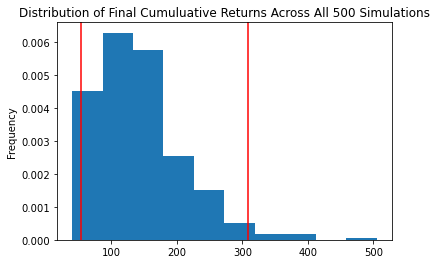

In [53]:
# Plot probability distribution and confidence intervals
distribution_plot_30 = MC_30yr.plot_distribution()

### Retirement Analysis

In [55]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_stats = MC_30yr.summarize_cumulative_return()

# Print summary statistics
print(summary_stats)

count           500.000000
mean            143.060706
std              66.225930
min              40.202289
25%              92.124888
50%             131.580014
75%             176.285224
max             504.803361
95% CI Lower     52.948102
95% CI Upper    308.323228
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [57]:
# Set initial investment
initial_investment = 20000

ci_lower = round((summary_stats[8] * initial_investment),2)
ci_upper = round((summary_stats[9] * initial_investment),2) 

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $1058962.04 and $6166464.56


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [58]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(summary_stats[8]*initial_investment,2)
ci_upper = round(summary_stats[9]*initial_investment,2)
# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $1588443.07 and $9249696.84
